# CPSC 330 Lecture 9

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements (5 min)
- Evaluation metrics True/False (10 min)
- Introducing some other classifiers (20 min)
- Break (5 mins)
- Ensembles: averaging (20 min)
- Ensembles: stacking (20 min)
- Summary

Piazza:

- Ensembles True/False questions

## Announcements

- hw schedule for the rest of the course posted at https://github.com/UBC-CS/cpsc330#homework-schedule
- hw4 posted, due Monday 11:59pm
- Evaluation metrics true/false: https://piazza.com/class/kb2e6nwu3uj23?cid=283
- Midterm format poll: https://piazza.com/class/kb2e6nwu3uj23?cid=281

## Learning objectives

- Explain 
- todo

In [19]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier
import graphviz

In [20]:
plt.rcParams['font.size'] = 16

In [125]:
from IPython.display import display

In [96]:
import re
import graphviz
from sklearn.tree import export_graphviz

def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(tree, out_file=None, feature_names=feature_names, class_names=tree.classes_.astype(str), impurity=False)
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    dot = re.sub(     '(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
    return graphviz.Source(dot)

## Introducing some other classifiers (20 min)

- SVM?
- Random forest
- XGB, Catboost?

In [40]:
cc_df = pd.read_csv('data/creditcard.csv', encoding='latin-1')

Today I will use a smaller data set for speed of the demos:

In [41]:
cc_df = cc_df.sample(frac=0.1)

In [42]:
df_train, df_test = train_test_split(cc_df, random_state=123)

In [43]:
df_train.shape

(21360, 31)

In [44]:
X_train = df_train.drop(columns=['Class'])
y_train = df_train['Class']

X_test = df_test.drop(columns=['Class'])
y_test = df_test['Class']

In [147]:
pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
]) 

In [151]:
score_method = 'average_precision'

In [152]:
lr_results = pd.DataFrame(cross_validate(pipe_lr, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
lr_results

fit_time       0.152092
score_time     0.004988
test_score     0.690253
train_score    0.773068
dtype: float64

In [47]:
dt = DecisionTreeClassifier(class_weight='balanced') # scaling not needed

In [153]:
dt_results = pd.DataFrame(cross_validate(dt, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
dt_results

fit_time       0.161050
score_time     0.002695
test_score     0.510938
train_score    1.000000
dtype: float64

How about some other classifiers?

In [75]:
from sklearn.ensemble import RandomForestClassifier

- This is basically the average of a bunch of random decision trees. 
- We'll talk about averaging later today!

In [50]:
rf = RandomForestClassifier(class_weight='balanced') # scaling not needed

In [154]:
rf_results = pd.DataFrame(cross_validate(rf, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
rf_results

fit_time       2.023708
score_time     0.024301
test_score     0.760333
train_score    1.000000
dtype: float64

This gets a better score!

In [155]:
summary = pd.DataFrame([lr_results, dt_results, rf_results], index=["logistic regression", "decision tree", "random forest"])
summary.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score
random forest,2.023708,0.024301,0.760333,1.000000
logistic regression,0.152092,0.004988,0.690253,0.773068
decision tree,0.161050,0.002695,0.510938,1.000000


### What are these random forests you speak of?

- They are a collection of decision trees.
- Each tree "votes" on the prediction, majority rules (more on this later).
- Each tree (and split) is limited in the number of features it can look at.
- Each tree is training on a slightly different version of the dataset. 

We can actually look at the sub-trees in a trained random forest:



Tree 1


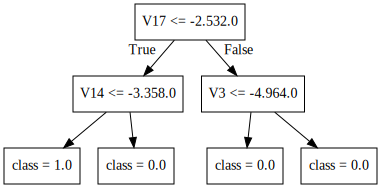



Tree 2


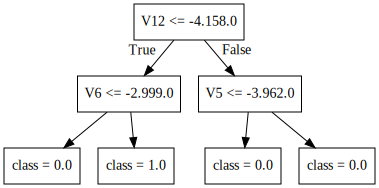



Tree 3


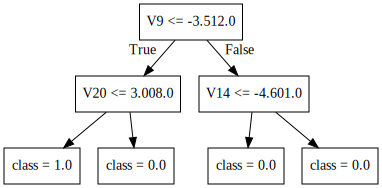

In [131]:
rf_demo = RandomForestClassifier(max_depth=2, n_estimators=3)
rf_demo.fit(X_train, y_train)
for i, tree in enumerate(rf_demo.estimators_):
    print("\n\nTree", i+1)
    display(display_tree(X_train.columns, tree))

Note that they look at different features. 

Some notable hyperparameters:

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)

In [143]:
# ??RandomForestClassifier

- We can also try some other tree-based classifiers from outside sklearn.
- There are more "fancy" are are **extremely popular**.  
- Over time, people created "sklearn-friendly" wrappers so that these classifiers are compatible with all that we know & love.
  - As long as they implement `fit` and `predict` and `predict_proba` and `score` we can plug them right in.
  - Important to note that all of these **do** implement `predict_proba` so we can use something like ROC AUC.
  - The probability scores come from the variation in the votes across trees, and other fancier sources.

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

`XGBClassifier` doesn't have an easy implementation of `class_weight='balanced'` AFAIK.

In [161]:
vc = y_train.value_counts()
vc = vc/vc.iloc[1]
vc

0    463.347826
1      1.000000
Name: Class, dtype: float64

In [162]:
classifiers = {
    'logistic regression' : pipe_lr,
    'decision tree' : dt,
    'random forest' : rf,
    'XGBoost' : XGBClassifier(scale_pos_weight=500), 
    'LightGBM' : LGBMClassifier(class_weight='balanced'),
    'CatBoost' : CatBoostClassifier(auto_class_weights='Balanced', verbose=0)
}

In [163]:
results = dict()
for name, classifier in classifiers.items():
    print(name)
    results[name] = pd.DataFrame(cross_validate(classifier, X_train, y_train, scoring=score_method, return_train_score=True)).mean()

logistic regression
decision tree
random forest
XGBoost
LightGBM
CatBoost


In [164]:
results = pd.DataFrame(results).T
results.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score
CatBoost,7.099218,0.005654,0.784137,1.000000
XGBoost,0.735794,0.006911,0.772250,1.000000
LightGBM,0.252483,0.010318,0.757898,1.000000
random forest,2.024333,0.024253,0.757476,1.000000
logistic regression,0.150894,0.004469,0.690253,0.773068
decision tree,0.176184,0.002757,0.516319,1.000000


My thoughts:

- Keep in mind all of the above is with:
  - Default hyperparameters (except `class_weight`)
  - A particular scoring metric
  - 5-fold CV
- All the trees totally overfit
  - We may do better by tweaking the hyperparameters
- Note that CatBoost took about 10x longer than XGBoost and the scores only differ by 1%
  - We took the mean of the sub-scores, but we might want to look more closely.

## Break (5 min)

<br><br>

## Ensembles: averaging (20 min)

Last time we trained a linear regression model:

In [24]:
lr = Ridge(alpha=100)
lr.fit(X_train_imp_encode, y_train_log);

In [25]:
print("Training MAPE: %.2f%%" % mape(y_train, np.exp(lr.predict(X_train_imp_encode))))

Training MAPE: 8.72%


In [26]:
print("Validation MAPE: %.2f%%" % mape(y_valid, np.exp(lr.predict(X_valid_imp_encode))))

Validation MAPE: 9.21%


We also tried a random forest:

In [27]:
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train_imp_encode, y_train_log);

In [28]:
print("Training MAPE: %.2f%%" % mape(y_train, np.exp(rf.predict(X_train_imp_encode))))

Training MAPE: 3.80%


In [29]:
print("Validation MAPE: %.2f%%" % mape(y_valid, np.exp(rf.predict(X_valid_imp_encode))))

Validation MAPE: 9.62%


And we can try an SVM:

In [30]:
svm = SVR()
svm.fit(X_train_imp_encode, y_train_log);

In [31]:
print("Training MAPE: %.2f%%" % mape(y_train, np.exp(svm.predict(X_train_imp_encode))))

Training MAPE: 6.68%


In [32]:
print("Validation MAPE: %.2f%%" % mape(y_valid, np.exp(svm.predict(X_valid_imp_encode))))

Validation MAPE: 8.78%


Question: can we combine these models?

In [34]:
estimators = [('ridge', Ridge(alpha=100)),
              ('random forest', RandomForestRegressor(random_state=123)),
              ('SVM regressor', SVR())]

In [35]:
averaging_model = VotingRegressor(estimators)

This `VotingRegressor` will predict the _average_ of its constituent classifiers.

In [36]:
averaging_model.fit(X_train_imp_encode, y_train_log);

Note: it seems sklearn requires us to actually call `fit` on the `VotingRegressor`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.

In [37]:
averaging_model.predict(X_valid_imp_encode)[5]

12.228460339812964

In [38]:
ridge_pred = averaging_model.named_estimators_['ridge'].predict(X_valid_imp_encode)[5]
ridge_pred

12.224610958721197

In [39]:
rf_pred = averaging_model.named_estimators_['random forest'].predict(X_valid_imp_encode)[5]
rf_pred

12.264407940093813

In [40]:
svm_pred = averaging_model.named_estimators_['SVM regressor'].predict(X_valid_imp_encode)[5]
svm_pred

12.196362120623878

In [41]:
(ridge_pred + rf_pred + svm_pred) / 3

12.228460339812964

- Above: so, indeed the overall prediction is the average of the 3 predictions.
- Below: let's see how well this model performs.

In [42]:
print("Training MAPE: %.2f%%" % mape(y_train, np.exp(averaging_model.predict(X_train_imp_encode))))

Training MAPE: 5.84%


In [43]:
print("Validation MAPE: %.2f%%" % mape(y_valid, np.exp(averaging_model.predict(X_valid_imp_encode))))

Validation MAPE: 8.41%


- What we did here was _model averaging_. 
- This is one (very popular) time of ensembling models.
- Question: how could the average do better than the best model???
  - From the perspective of the best estimator (in this case linear regression), why are you adding on worse estimators??
- This is a bit easier to see with classification.
- For classification we have:

In [44]:
from sklearn.ensemble import VotingClassifier

- `VotingClassifier` takes the majority vote from its constituent classifiers.
- Here's how this can work:



| Example | LR    | RF     | SVM    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


- In short, as long as the different models make different mistakes, this can work.

This is amazing, why not always do this?

1. `fit`/`predict` time.
2. Reduction in interpretability.
3. Reduction in code maintainability (e.g. Netflix prize).

Back to ensembling: when can I do this?

- You can comebine completely different estimators, or similar estimators.
  - (In fact, a random forest itself is an ensemble of decision trees.)
- But you can also try different hyperparameter values:

In [41]:
estimators = [('ridge', Ridge(alpha=100)),
              ('rf 10', RandomForestRegressor(n_estimators=10)),
              ('rf 100', RandomForestRegressor(n_estimators=100)),
              ('SVM rbf',  SVR(kernel='rbf')),
              ('SVM poly', SVR(kernel='poly'))]

In [42]:
averaging_model = VotingRegressor(estimators)
averaging_model.fit(X_train_imp_encode, y_train_log);

In [43]:
print("Training MAPE: %.2f%%" % mape(y_train, np.exp(averaging_model.predict(X_train_imp_encode))))

Training MAPE: 5.28%


In [44]:
print("Validation MAPE: %.2f%%" % mape(y_valid, np.exp(averaging_model.predict(X_valid_imp_encode))))

Validation MAPE: 8.49%


## Ensembles: stacking (20 min)

- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, instead use them as inputs to another model.

In [45]:
from sklearn.ensemble import StackingClassifier

In [46]:
estimators = {'ridge' : Ridge(alpha=100),
              'rf 10' : RandomForestRegressor(n_estimators=10),
              'rf 100' : RandomForestRegressor(n_estimators=100),
              'SVM rbf' :  SVR(kernel='rbf'),
              'SVM poly' : SVR(kernel='poly')
               }

In [47]:
stacking_model = StackingRegressor(estimators.items())
stacking_model.fit(X_train_imp_encode, y_train_log);

Here is the input features (X) to the meta-model:

In [68]:
preds = np.concatenate([estimator.predict(X_train_imp_encode)[:,None] for estimator in stacking_model.estimators_], axis=1)
pd.DataFrame(preds, columns=list(estimators.keys())).head()

,ridge,rf 10,rf 100,SVM rbf,SVM poly
0,12.068502,12.070372,12.073288,12.087978,12.071595
1,12.947864,12.963994,12.973918,12.998336,12.988760
2,12.327807,12.346029,12.356182,12.320548,12.326201
3,12.081258,12.002698,11.987009,12.098965,12.088716
4,11.795430,11.778579,11.817743,11.830349,11.828437


Each column contains the predictions from one of the original estimators.

- If the meta-model is linear regression (which it is by default), you are taking a _weighted_ average and learning the weights from the data.

In [48]:
print("Training MAPE: %.2f%%" % mape(y_train, np.exp(stacking_model.predict(X_train_imp_encode))))

Training MAPE: 5.26%


In [49]:
print("Validation MAPE: %.2f%%" % mape(y_valid, np.exp(stacking_model.predict(X_valid_imp_encode))))

Validation MAPE: 8.37%


By default, the meta-estimator is a linear regression (ridge), so we can look at the coefficients. 
  - (To be precise, the default uses `RidgeCV`, which automatically tunes `alpha` using cross-validation.)

In [50]:
stacking_model.final_estimator_.coef_

array([0.12302678, 0.17246328, 0.19786762, 0.39538227, 0.13589923])

- It seems that the RBF SVM is "counting for more".
- We can also try a different final estimator:

In [55]:
stacking_model_tree = StackingRegressor(estimators.items(), 
                                        final_estimator=DecisionTreeRegressor(max_depth=3))
stacking_model_tree.fit(X_train_imp_encode, y_train_log);

In [56]:
print("Training MAPE: %.2f%%" % mape(y_train, np.exp(stacking_model_tree.predict(X_train_imp_encode))))

Training MAPE: 9.41%


In [57]:
print("Validation MAPE: %.2f%%" % mape(y_valid, np.exp(stacking_model_tree.predict(X_valid_imp_encode))))

Validation MAPE: 10.90%


The results are pretty terrible. But at least we can look at the tree:

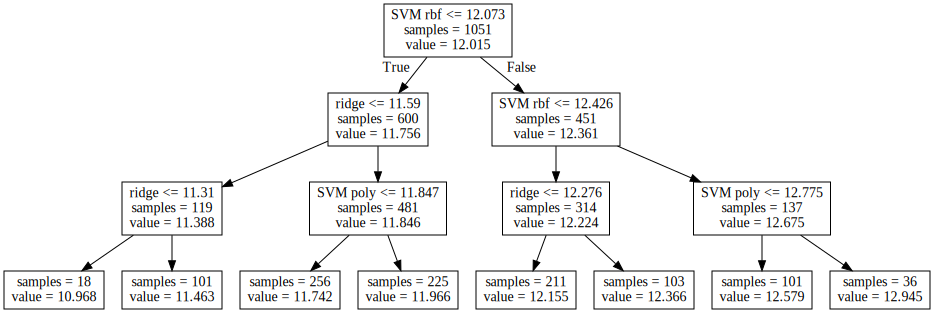

In [58]:
graphviz.Source(export_graphviz(stacking_model_tree.final_estimator_,
                                out_file=None,
                                feature_names=list(estimators.keys()),
                                impurity=False))

Let's check out our results on the test set:

In [59]:
print("Test MAPE: %.2f%%" % mape(y_test, np.exp(lr.predict(X_test_imp_encode))))

Test MAPE: 9.31%


In [60]:
print("Test MAPE: %.2f%%" % mape(y_test, np.exp(averaging_model.predict(X_test_imp_encode))))

Test MAPE: 8.52%


In [61]:
print("Test MAPE: %.2f%%" % mape(y_test, np.exp(stacking_model.predict(X_test_imp_encode))))

Test MAPE: 8.65%


# TODO

- From H2O AutoML talk: use Random Search, then Stack all the models. Apparently works super well as a general rule of thumb.
- For random forests, can visualize the sub-trees with graphviz.

## Summary 

- a
- b

## True/False questions (Piazza)

1. I can decide to average different models even _after_ I (or someone else) have already trained them.
2. Let estimators A, B, and C have scores of 90%, 70%, and 70%, respectively. Then, the maximum score of an ensemble is 90%. 
3. Let estimators A, B, and C have scores of 70%, 70%, and 70%, respectively. Then, the minimum score of an ensemble is 70%.
4. Ensembling often increase your score but they also increase the time spent fitting and predicting.


<br><br><br><br><br><br><br><br><br>